# Análisis y procesamiento de señales - Trabajo semanal Nº 8 #
# Aramayo Yohana Valentina #

En esta tarea semanal retomamos el filtrado de una señal de ECG pero en esta oportunidad nos centramos en el filtrado más exigente que hay que realizar en este tipo de señales. Se trata del filtrado de la línea de base del ECG, de muy baja frecuencia y que introduce una gran cantidad de energía. En este caso, vamos a hacer uso de filtros no lineales. En los filtros no lineales no podemos relacionar la salida del filtro con la señal de entrada. 

Los dos primeros filtros que presentaremos - filtros de mediana e interpolación con cubic spline - son métodos que permiten estimar la línea de base del ECG para luego restar del ECG y obtener un ECG son línea de base, filtrado. 


In [53]:
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import find_peaks, medfilt
from scipy.interpolate import CubicSpline
# Cargar la señal ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Lectura de ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead']).flatten()
# Extraer las señales
# Extraer las señales
ecg_one_lead = mat_struct['ecg_lead'].flatten()
ecg_one_lead=ecg_one_lead/np.std(ecg_one_lead)
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs_pattern= mat_struct['qrs_pattern1'].flatten() #Una forma típica de latido (plantilla)
qrs_indices = mat_struct['qrs_detections'].flatten() #Índices temporales (en muestras)


## Filtro de mediana ##
La mediana encuentra el punto central donde se tiene el mismo área tanto de izquierda como a derecha. Es el valor de x que parte en 2 nuestra distribución.

El filtro de mediana es un filtro no lineal que actúa tomando una ventana de muestras que se desplaza a lo largo de la señal, muestra a muestra, y reemplaza el valor central de esa ventana por la mediana de todos los valores contenidos en ella. Esta operación se repite para cada muestra, generando una señal suavizada que conserva bien la forma general, pero es robusta frente a valores extremos o picos. 

Si vos queres hacerte insensible a una interferencia de 50Hz tenes que tomar una ventana de 20ms. Entonces, acá vamos a tener una ventana múltiplo de 20 ms al igual que en el de spline(donde explico mejor lo de la interferencia de 50 Hz). Sin embargo, debido a la no linealidad del operador mediana, es más difícil predecir la presencia de ceros de transmisión (frecuencias que el filtro atenúa fuertemente), y por lo tanto, su comportamiento frecuencial es menos claro que el de un filtro lineal.

Hay que tomar una ventana más ancho que el complejo de QRS, para que tiren la mediana para abajo y entonces las estimación de mediana represente mucho mejor la centralidad, la línea de base. A diferencia del promedio, donde unos pocos valores atípicos (por ejemplo, el QRS o artefactos) pueden dominar el valor de salida, la mediana es robusta frente a estos valores extremos y proporciona una mejor estimación de la posición central o línea de base. 

Si lo hago demasiado grande al ancho lo que me va a pasar es que la alinealidad me tira la mediana más abajo de donde debería ser. Tiene que ser más ancho que el complejo QRS  pero que no llegue a tocar las otras ondas. Suponiendo que tenemos poco segmento de línea de base podemos hacer varias pasadas, en la primera una ventana chica. En la segunda pasada usamos una ventana más ancha.
En la primera pasada, se utilizó una ventana pequeña para preservar detalles. En una segunda pasada, se aplica una ventana más ancha para mejorar la estimación de la línea de base.

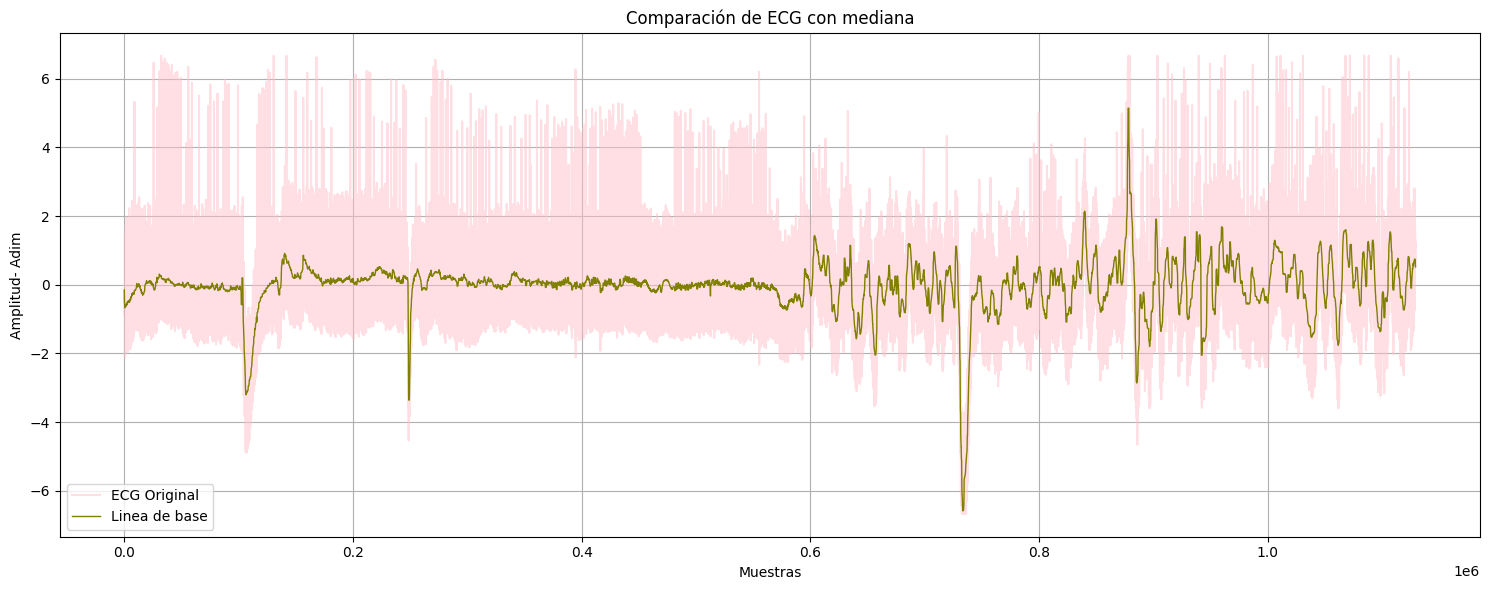

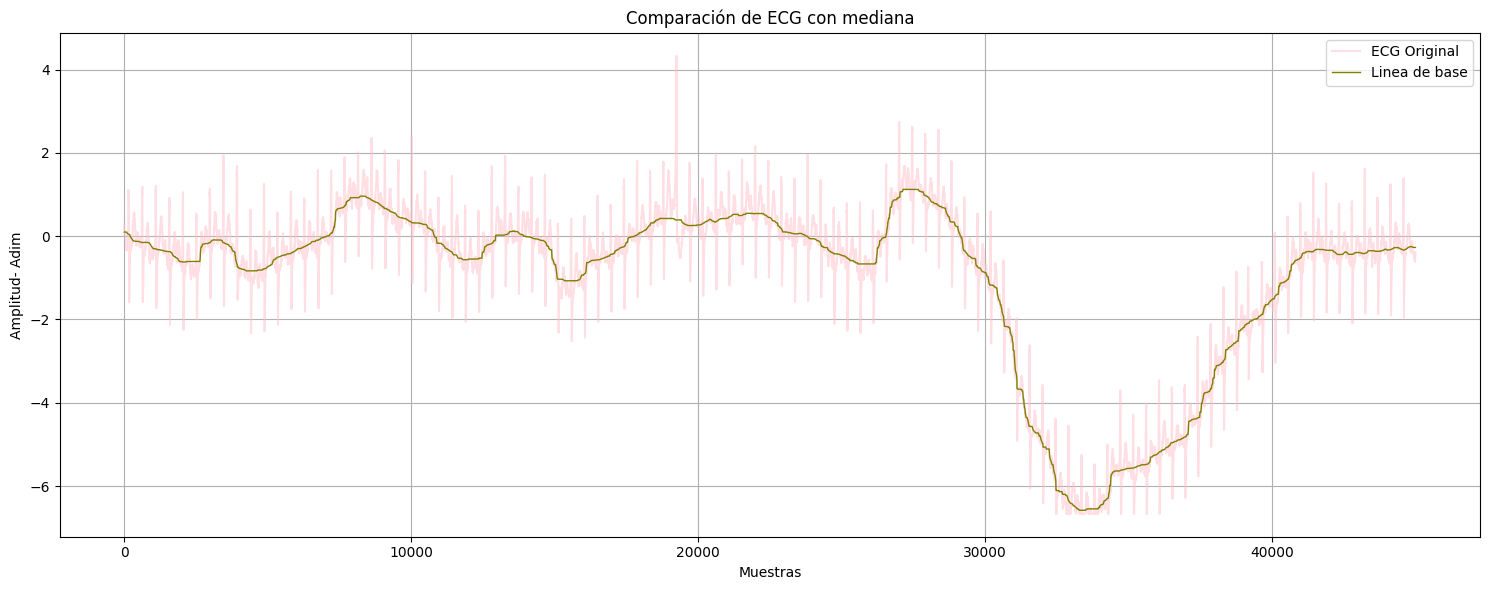

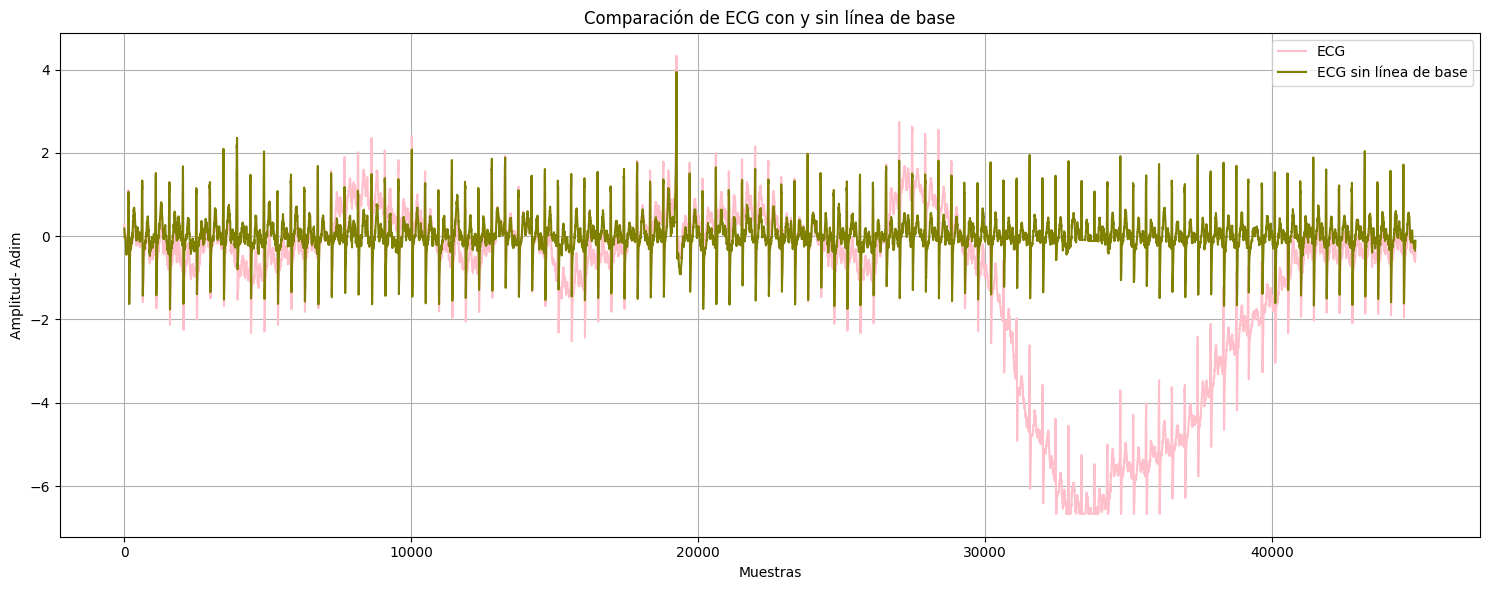

In [63]:
# Definir kernel_size 
kernel_size = 201
kernel_size_2 = 1201
# Lectura de ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead']).flatten()
ecg_one_lead=ecg_one_lead/np.std(ecg_one_lead)
# N = len(ecg_one_lead) 
ecg=ecg_one_lead[700000:745000]
medfilt(ecg, kernel_size=None)

# Aplicar filtro mediano ventana 200ms
ecg_filtradovgrande = medfilt(ecg, kernel_size=kernel_size)

# Aplicar filtro mediano ventana 600ms
ecg_filtradovchica=medfilt(ecg_filtradovgrande, kernel_size=kernel_size_2)


# %%
# Toda la senal 
# Aplicar filtro mediano ventana 200ms
ecg_filtradovgrande2 = medfilt(ecg_one_lead, kernel_size=kernel_size)

# Aplicar filtro mediano ventana 600ms
ecg_filtradovchica2=medfilt(ecg_filtradovgrande2, kernel_size=kernel_size_2)
# Gráfica
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead, label='ECG Original', alpha=0.5,  color='pink')

plt.plot(ecg_filtradovchica2, label='Linea de base', linewidth=1,  color='olive')
plt.xlabel('Muestras')
plt.ylabel('Amplitud- Adim')
plt.title('Comparación de ECG con mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfica
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead[700000:745000], label='ECG Original', alpha=0.5,  color='pink')
plt.plot(ecg_filtradovchica2[700000:745000], label='Linea de base', linewidth=1,  color='olive')
plt.xlabel('Muestras')
plt.ylabel('Amplitud- Adim')
plt.title('Comparación de ECG con mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# %% Resto linea de base al ECG 

# cs = CubicSpline(x, medias_segmentos, extrapolate=True)
ECG_sin_b = ecg_one_lead - ecg_filtradovchica2
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead[700000:745000], label='ECG', color='pink')
plt.plot(ECG_sin_b[700000:745000], label='ECG sin línea de base', color='olive')
# plt.xlim([400, 410])
plt.xlabel('Muestras')
plt.ylabel('Amplitud- Adim')
plt.title('Comparación de ECG con y sin línea de base')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Cubic spline ##
En el método de interpolación con splines cúbicos, buscamos estimar la línea de base, que denotamos como b̂ (b sombrerito). Para realizar una buena estimación de b̂, necesitamos seleccionar una región del ECG que no contenga información eléctrica significativa. Idealmente una región silenciosa, donde haya baja actividad cardíaca. Una de las zonas más utilizadas para esto es el segmento entre el final de la onda T y el comienzo del complejo QRS, ya que suele estar libre de componentes importantes del ECG (aunque puede haber algo de repolarización residual).
Tomamos los puntos fiduciales (picos de mayor amplitud de los complejos qrs y volvemos  90ms hacia atrás donde no encontramos partes info de ECG. Esta comprende una gran región para estimar b sombrerito. Una buena duración para esta ventana podría ser 20 ms, o algún múltiplo entero de 20 ms. Para quedarse con una buena estimación de b que no está afectada por la interferencia de 50 ciclos. 

Si pongo ventana de 20ms (periodo) tengo cero de transmisión en 50Hz (frecuencia), por eso los mitigo y también sus armónicos ¿por qué?  bueno porque si haces el promedio de una senoidal en un periodo es cero.

Realizamos esta estimación en la misma sección del ciclo cardíaco a lo largo de toda la señal. A partir de estas estimaciones de la línea de base (b̂), registramos los instantes en los que fueron tomadas, es decir, las muestras n correspondientes.
Con estas coordenadas (n, b̂) , podemos aplicar un método de interpolación, y así obtener una señal continua que representa la línea de base a lo largo del tiempo. Para ello, utilizamos interpolación con splines cúbicos, lo que nos permite reconstruir una estimación suave y continua de la línea de base del ECG.

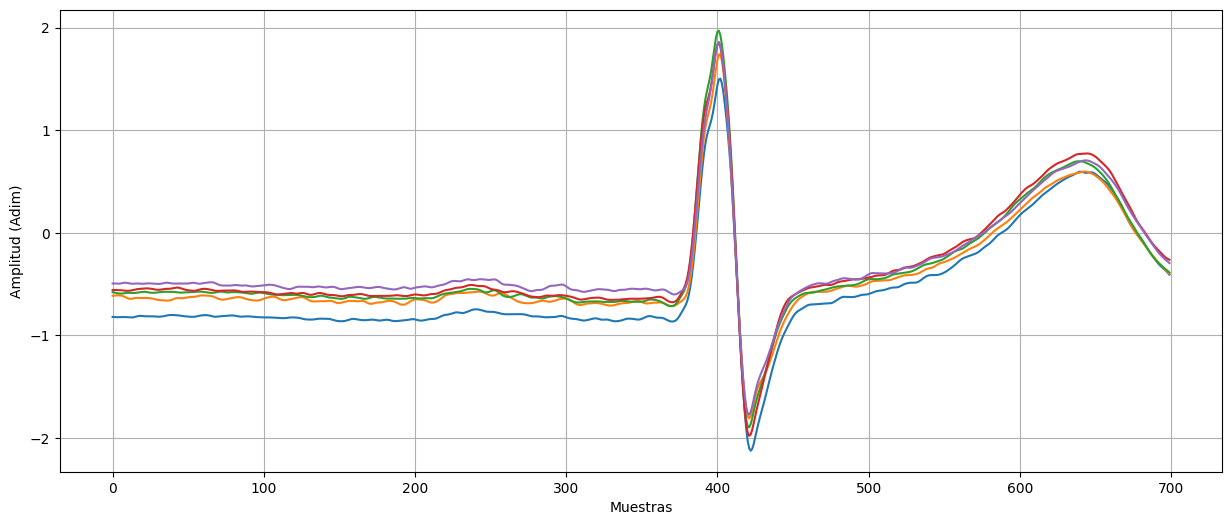

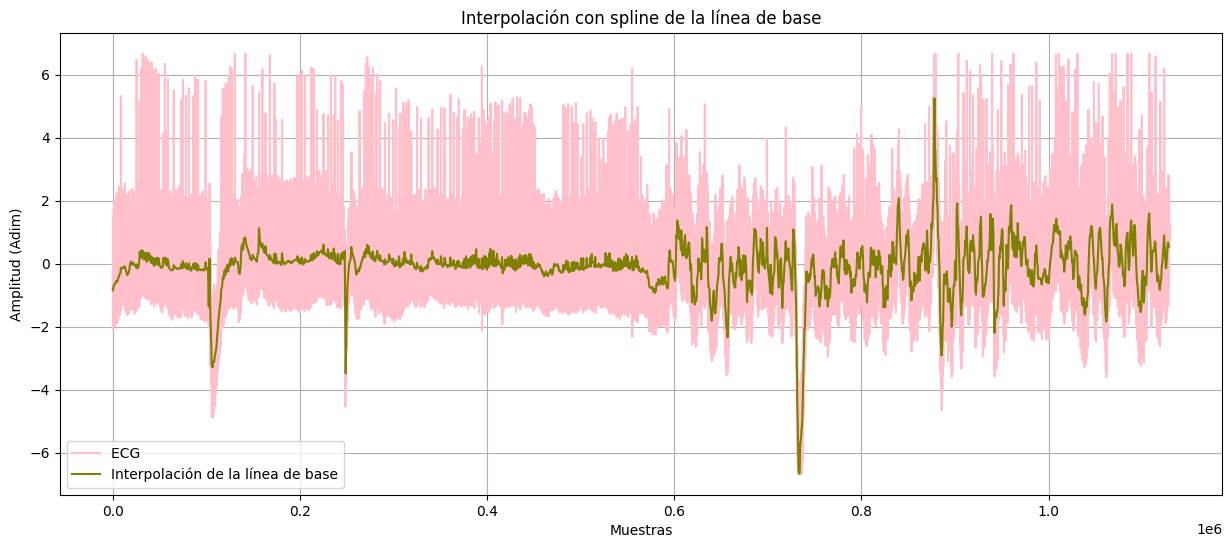

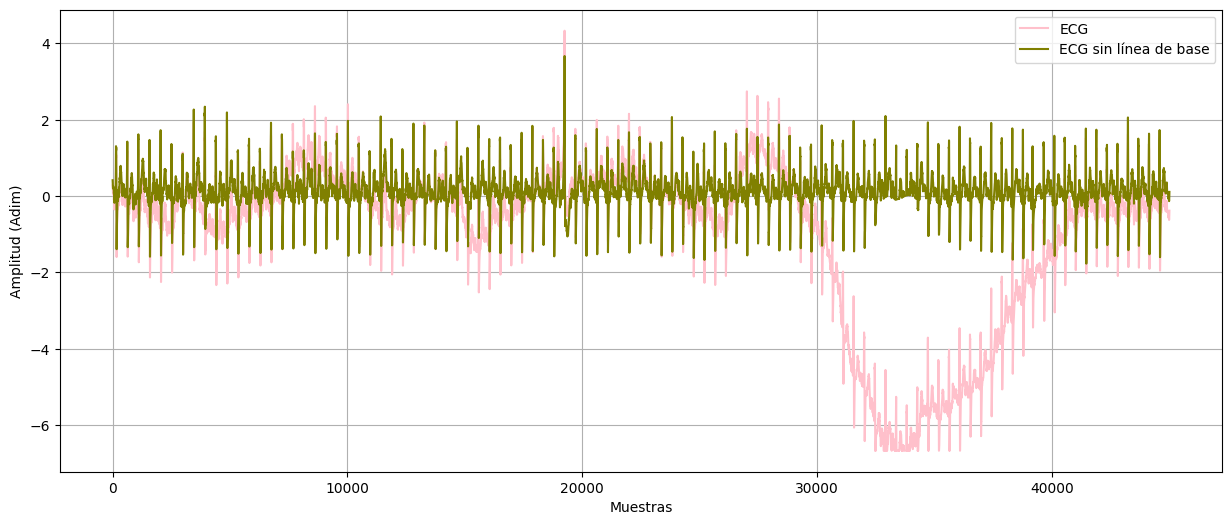

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.interpolate import CubicSpline
def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Lectura de ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead']).flatten()
ecg_one_lead=ecg_one_lead/np.std(ecg_one_lead)
qrs_indices = mat_struct['qrs_detections'].flatten()
pre = 400  # muestras antes del QRS 
post = 300
segmentos = []
for idx in qrs_indices:
    if idx - pre >= 0 and idx + post< len(ecg_one_lead):
        segmento = ecg_one_lead[idx - pre :  idx+post]
        segmentos.append(segmento)

# Convertir a array 2D: cada fila es un segmento
segmentos_array = np.array(segmentos)

# Graficar los primeros 5 latidos superpuestos
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.plot(segmentos_array[i], label=f'Segmento {i+1}')

plt.xlabel('Muestras')
plt.ylabel('Amplitud (Adim)')
plt.grid(True)
plt.show()

#%%
# Parámetros de ventana alrededor del QRS
pre = 90  # muestras antes del QRS 
post = 20  # muestras 20ms despues de pre

# Extraer segmentos alrededor de los picos QRS
segmentos = []
for idx in qrs_indices:
    if idx - pre >= 0 and idx - pre + post < len(ecg_one_lead):
        segmento = ecg_one_lead[idx - pre :  idx - pre + post]
        segmentos.append(segmento)

# Convertir a array 2D: cada fila es un segmento
segmentos_array = np.array(segmentos)
# %% Estimacion de b en cada segmentos - grafico ECG ruidoso con linea de base 

# Calcular la media de cada segmento (fila)
medias_segmentos = np.mean(segmentos_array, axis=1)
x=qrs_indices - pre
cs = CubicSpline(x, medias_segmentos)
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead, color='pink', label= 'ECG ')
plt.ylabel('Amplitud (Adim)')
plt.xlabel('Muestras')
plt.plot(x, cs(x), color='olive', label= 'Interpolación de la línea de base')
plt.title("Interpolación con spline de la línea de base")
plt.legend()
plt.grid(True)
plt.show()

# %% Resto linea de base al ECG 

cs = CubicSpline(x, medias_segmentos, extrapolate=True)
spline_full = cs(np.arange(len(ecg_one_lead)))
ECG_sin_b = ecg_one_lead - spline_full
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead[700000:745000], color='pink', label='ECG')
plt.plot(ECG_sin_b[700000:745000], color='olive', label='ECG sin línea de base')
plt.ylabel('Amplitud (Adim)')
plt.xlabel('Muestras')
# plt.xlim([400, 410])
plt.legend()
plt.grid(True)

# Matched Filter #

En el filtro adaptado, se correlaciona un patrón de una forma determinada de latido, supongamos latido normal con la señal de ECG. En este caso, el patrón provisto en el campo qrs_pattern1.. La correlación cruzada mide el grado de similitud entre dos señales desplazadas una respecto a la otra. El resultado es una nueva señal donde los máximos locales indican los instantes en los que la señal de ECG se parece más al patrón, es decir, probables posiciones de latidos.Para aplicar este método lo que hago es observar los picos de máxima amplitud de la correlación. Luego al visualizar esto en el ecg no es que voy a observar una marca directamente en el pico del complejo qrs sino que este punto va a detectar un latido con lo cual puede encontrarse en cualquier lado de un latido aunque mayormente centrado en el complejo qrs o un poco corrido de él. 
Sí gráfico una ventana que contenga al qrs como centro voy a graficar latidos (aunque puede ser que algunas veces no por limitaciones del método).
La utilidad que tiene el método es obtener la cantidad de latidos totales en cierto periodo de tiempo. Esto tiene una serie de ventajas: podríamos utilizarlo para calcular frecuencia cardiaca o separar latidos para estudiar la morfología. Otra ventaja radica en que mejora la relación señal-ruido (SNR), ya que realza las regiones que coinciden con la forma del patrón QRS y atenúa el resto (ondas P, T, artefactos, etc.).
Algunas limitaciones del método es que hay una dependencia del patrón qrs si este no se parece a la señal real el filtro no será muy efectivo encontrando los latidos. Además puede detectar latidos donde no los hay (por coincidencias accidentales) o no detectarlos si están muy distorsionados o afectados por ruido.


Para la comparación de las detecciones obtenidas con las que se incluyen en la variable qrs detections se me ocurrió marcar con líneas donde se identifican los latidos a lo largo del ECG. Se propone una métrica para detectar la performance del filtro teniendo en cuenta la sensibilidad del mismo. El mismo consiste en calcular la proporción entre los latidos proporcionados por mat struct y los detectados mediante matched filter.  Si la proporción es mayor 1 estamos detectando latidos que no son verdaderos. En cambio si obtenemos una proporción demasiado menor a uno no estaremos identificando una gran cantidad de latidos. Además se incorporó una tolerancia de 100 ms para la comparación entre los latidos detectados. Se verifica cuántos picos detectados coinciden con latidos reales dentro de una tolerancia de 100 muestras (equivalente a ±100 ms si el muestreo es de 1000 Hz). 
Notamos que en este caso obtenemos una sensibilidad del 99%, es decir hemos logrado detectar casi el total de los latidos que posee este electrocardiograma. Esto puede deberse al grado de similitud entre la onda qrs y el qrs pattern que lo provee el mismo archivo de ecg en este caso, quizas al compararlo con otro patron esta relacion de coincidencia cambiaria drasticamente.




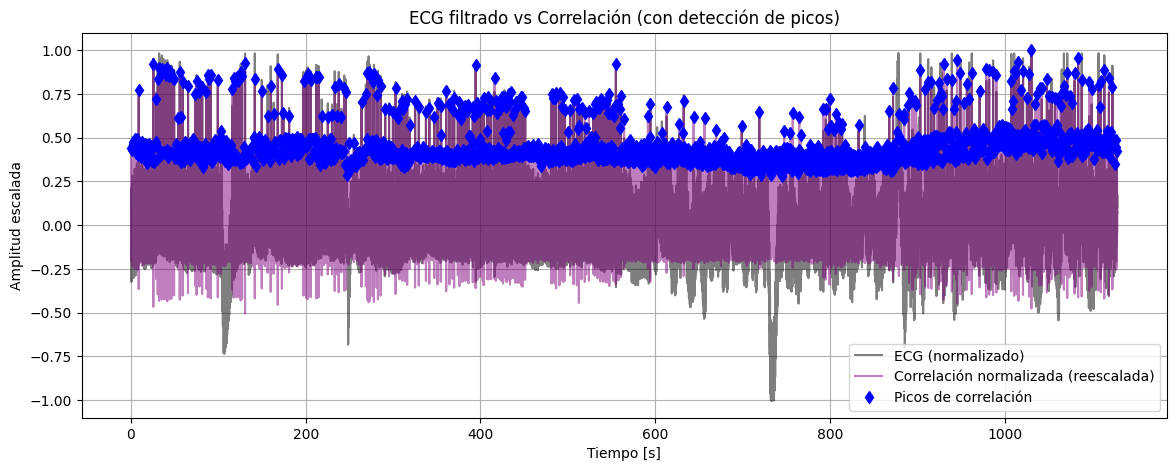

In [41]:
from scipy.signal import find_peaks, correlate
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import scipy.io as sio
def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Cargar la señal ECG
fs= 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')

# Extraer las señales
ecg_one_lead = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs_pattern= mat_struct['qrs_pattern1'].flatten() #Una forma típica de latido (plantilla)
qrs_indices = mat_struct['qrs_detections'].flatten() #Índices temporales (en muestras)

# Paso 1: Normalización
ecg_filtrada_norm = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)
qrs_pattern_norm = (qrs_pattern - np.mean(qrs_pattern)) / np.std(qrs_pattern)

# Paso 2: Correlación normalizada
corr_norm = sig.correlate(ecg_filtrada_norm, qrs_pattern_norm, mode='same')

# Paso 3: Reescalado
ecg_rescaled = ecg_filtrada_norm / np.max(np.abs(ecg_filtrada_norm))
corr_rescaled = corr_norm / np.max(np.abs(corr_norm))
# %%
# Paso 4: Detección de picos en la correlación reescalada

threshold = 0.25  # Umbral relativo al máximo
peaks, properties = find_peaks(corr_rescaled, height=threshold, distance=200)
 
t_ecg=np.arange(len(corr_rescaled))/fs
# %%
# Paso 5: Gráfico conjunto

plt.figure(figsize=(14, 5))
plt.plot(t_ecg, ecg_rescaled, label='ECG (normalizado)', alpha= 0.5,color='black')
plt.plot(t_ecg, corr_rescaled, label='Correlación normalizada (reescalada)', alpha=0.5, color='purple')
plt.plot(t_ecg[peaks], corr_rescaled[peaks], 'bd', label='Picos de correlación')
plt.title('ECG filtrado vs Correlación (con detección de picos)')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud escalada")
plt.legend()
plt.grid(True)
plt.show()

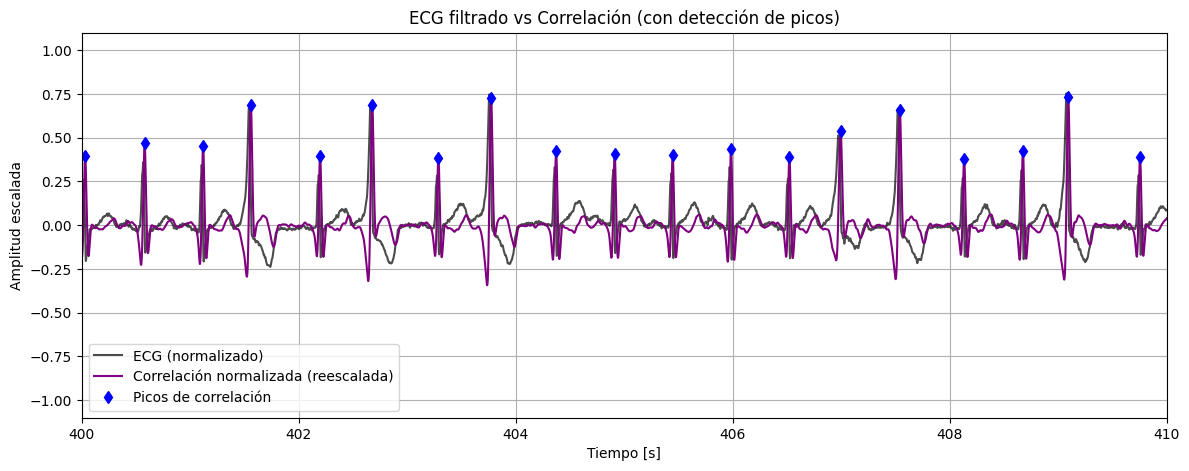

In [8]:
# Paso 5: Gráfico conjunto cierto intervalo

plt.figure(figsize=(14, 5))
plt.plot(t_ecg, ecg_rescaled, label='ECG (normalizado)', alpha=0.7, color='black')
plt.plot(t_ecg, corr_rescaled, label='Correlación normalizada (reescalada)', alpha=1, color='purple')
plt.plot(t_ecg[peaks], corr_rescaled[peaks], 'bd', label='Picos de correlación')
plt.title('ECG filtrado vs Correlación (con detección de picos)')
plt.xlim([400, 410])
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud escalada")
plt.legend()
plt.grid(True)
plt.show()

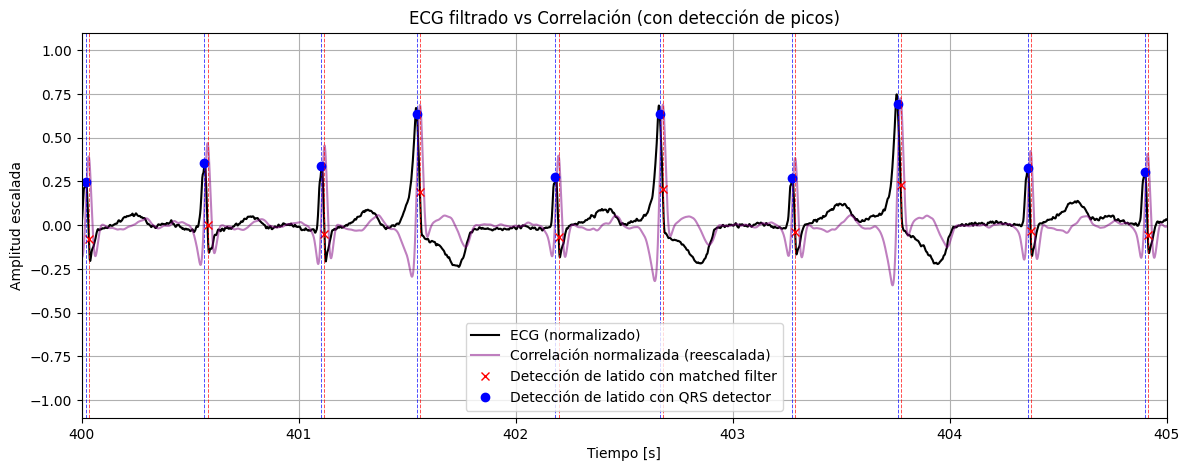

In [45]:
# Paso 5: Gráfico conjunto cierto intervalo

plt.figure(figsize=(14, 5))

# Señales
plt.plot(t_ecg, ecg_rescaled, label='ECG (normalizado)', alpha=1, color='black')
plt.plot(t_ecg, corr_rescaled, label='Correlación normalizada (reescalada)', alpha=0.5, color='purple')

# Detecciones
plt.plot(t_ecg[peaks], ecg_rescaled[peaks], 'rx', label='Detección de latido con matched filter')  # en rojo
plt.plot(t_ecg[qrs_indices], ecg_rescaled[qrs_indices], 'bo', label='Detección de latido con QRS detector')  # en azul

# Líneas punteadas en los picos de ambos métodos (dentro del intervalo)
for p in t_ecg[peaks]:
    if 400 <= p <= 405:
        plt.axvline(x=p, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

for q in t_ecg[qrs_indices]:
    if 400 <= q <= 405:
        plt.axvline(x=q, color='blue', linestyle='--', linewidth=0.7, alpha=0.7)

# Estética
plt.title('ECG filtrado vs Correlación (con detección de picos)')
plt.xlim([400, 405])
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud escalada")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# %%
# Tolerancia en muestras para considerar que un latido fue detectado correctamente
tolerancia = 100 #100 muestras=100ms

# Contador de coincidencias
coincidencias = 0

# Recorremos los latidos detectados por correlación
for p in peaks:
    # Si hay al menos un qrs en el archivo cerca de este latido detectado, se cuenta como coincidencia
    if np.any(np.abs(qrs_indices - p) <= tolerancia):
        coincidencias += 1

# Proporción de detecciones correctas respecto al total de latidos del archivo
proporcion_detectados = coincidencias / len(qrs_indices)
print(f"Proporción de detecciones correctas (matcher vs archivo): {proporcion_detectados:.2%}")


Proporción de detecciones correctas (matcher vs archivo): 99.79%


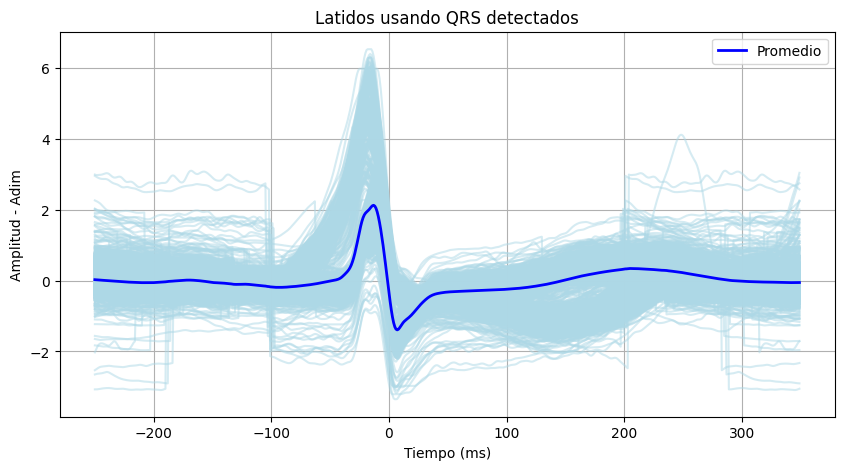

<Figure size 1200x600 with 0 Axes>

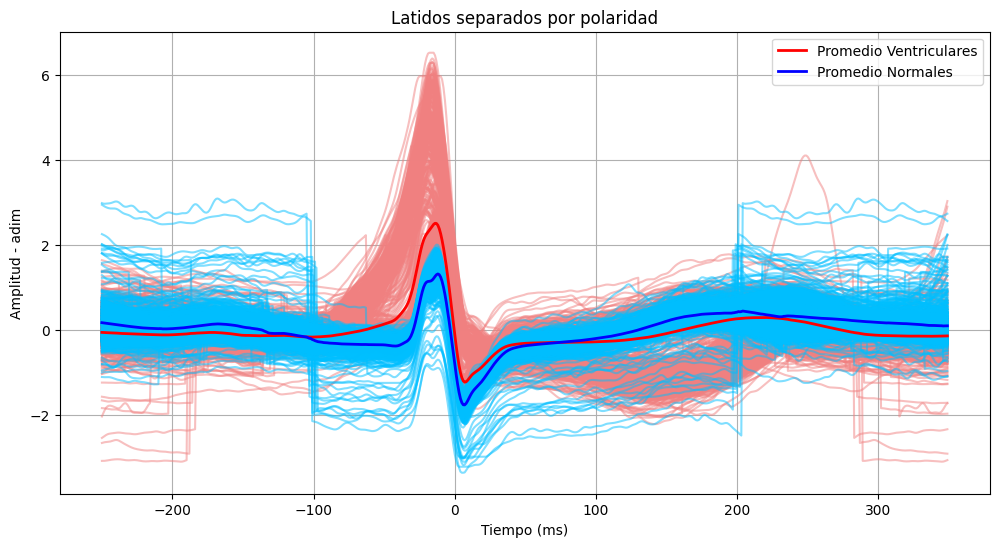

In [59]:
# %%

# VER LATIDOS SUPERPUESTOS CON QRS DETECTADO EN MAT STRUCT
# Paso 5: Comparación de latidos superpuestos

pre = 250  # muestras antes del QRS
post = 350  # muestras después
t = np.arange(-pre, post) * 1000 / fs  # eje en ms

def extraer_segmentos(indices, señal):
    segmentos = []
    for idx in indices:
        if idx - pre >= 0 and idx + post < len(señal):
            segmento = señal[idx - pre : idx + post]
            segmento -= np.mean(segmento)
            segmentos.append(segmento)
    return np.array(segmentos)

# 1. Latidos usando QRS detectados
segmentos_mat = extraer_segmentos(peaks, ecg_filtrada_norm)

plt.figure(figsize=(10,5))
for i in range(len(segmentos_mat)):
    plt.plot(t, segmentos_mat[i], color='lightblue', alpha=0.5)
plt.plot(t, np.mean(segmentos_mat, axis=0), color='blue', label='Promedio', linewidth=2)
plt.title('Latidos usando QRS detectados')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud - Adim')
plt.grid(True)
plt.legend()
plt.show()

# 2. Latidos usando detección propia (correlación)
segmentos_detectados = extraer_segmentos(peaks, ecg_filtrada_norm)

plt.figure(figsize=(12,6))

# Supongamos que "segmentos_detectados" es tu array de latidos (cada fila es un latido)
ventana_central = slice(pre - 50, pre + 50)  # Por ejemplo, +/-50 muestras alrededor del centro

positivos = []
negativos = []

for latido in segmentos_detectados:
    centro = latido[ventana_central]
    max_abs = np.max(np.abs(centro))
    if np.max(centro) == max_abs:
        positivos.append(latido)
    else:
        negativos.append(latido)

positivos = np.array(positivos)
negativos = np.array(negativos)

# Ahora los grafico separados
plt.figure(figsize=(12, 6))
for s in positivos:
    plt.plot(t, s, color='lightcoral', alpha=0.5)
for s in negativos:
    plt.plot(t, s, color='deepskyblue', alpha=0.5)

# Promedio general
plt.plot(t, np.mean(positivos, axis=0), color='red', label='Promedio Ventriculares', linewidth=2)
plt.plot(t, np.mean(negativos, axis=0), color='blue', label='Promedio Normales', linewidth=2)

plt.title("Latidos separados por polaridad")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Amplitud - adim")
plt.grid(True)
plt.legend()
plt.show()